In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
from convokit import Corpus, download
from convokit import HyperConvo
import numpy as np
import pickle

In [4]:
os.chdir('convokit/tensors')

In [5]:
import utils

In [6]:
os.listdir()

['demo', '__init__.py', '__pycache__', 'utils.py', 'data']

In [7]:
with open('data/hypergraph_tensor.p', 'rb') as f:
    tensor = pickle.load(f)

In [8]:
with open('data/rank_to_factors.p', 'rb') as f:
    rank_to_factors = pickle.load(f)

In [9]:
tensor.shape

(9, 10000, 164)

In [10]:
factors = rank_to_factors[9]

In [11]:
factors[0].shape

(9, 9)

In [12]:
factors[1].shape

(10000, 9)

In [13]:
factors[2].shape

(164, 9)

In [14]:
with open('data/subreddits.p', 'rb') as f:
    subreddits = pickle.load(f)

In [15]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [16]:
import pandas as pd

In [17]:
df = pd.DataFrame(factors[1])

In [18]:
df['subreddits'] = subreddits

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,subreddits
0,0.008697,0.000792,0.000539,0.071000,0.057662,0.057399,-0.104448,-0.054581,0.089074,askscience
1,0.003533,0.008221,0.000680,0.075819,0.003311,-0.015890,0.003553,0.014978,0.081708,hiphopheads
2,0.016550,-0.011889,0.016083,0.077753,0.024160,0.098062,-0.081027,-0.058975,0.106615,DotA2
3,0.007262,0.002142,0.001870,0.077753,0.008923,0.046398,-0.086384,-0.014239,0.087071,soccer
4,0.003004,0.016513,-0.008518,0.080212,-0.060908,-0.013426,0.022538,0.005725,0.054135,technology


In [20]:
subreddit_means = df.groupby('subreddits').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

In [21]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

In [22]:
import matplotlib.pyplot as plt

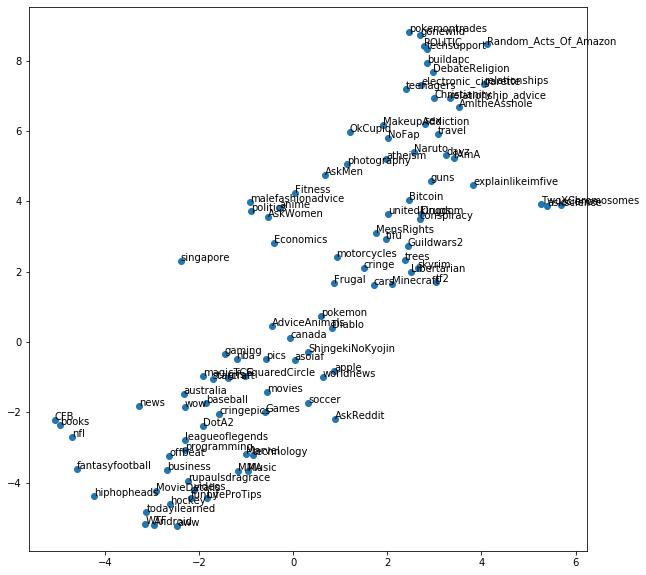

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

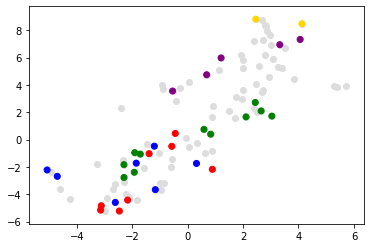

In [24]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

In [25]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [26]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [27]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                    p2      dist
3898         worldnews  0.001043
3833  ShingekiNoKyojin  0.002017
3810            Diablo  0.002373
3840            asoiaf  0.002510
3886            soccer  0.002692
3816             Games  0.004317
3868            movies  0.004494
3875           pokemon  0.004605
3848            canada  0.004718
3874              pics  0.005199

politics
                     p2      dist
7766  malefashionadvice  0.002571
7705           AskWomen  0.002652
7737              anime  0.003972
7714            Fitness  0.007320
7703             AskMen  0.010323
7767        motorcycles  0.010736
7710             Diablo  0.011414
7704          AskReddit  0.011570
7798          worldnews  0.011978
7738              apple  0.012777

leagueoflegends
                   p2      dist
6478      programming  0.000234
6411            DotA2  0.000420
6472          offbeat  0.000453
6447         business  0.001050
6444         baseball  0.001440
6499              wow  0.001758
6481  

In [47]:
num_subreddits = 7
for component_idx in range(9):
    print("For component index: {}".format(component_idx))
    
    subreddits_for_component = list(subreddit_df.sort_values(by=[component_idx])[[component_idx]].index)
    print("Lowest: {}".format(subreddits_for_component[:num_subreddits]))
    print("Highest: {}".format(subreddits_for_component[-num_subreddits:][::-1]))
    
    print()

For component index: 0
Lowest: ['WTF', 'todayilearned', 'aww', 'MovieDetails', 'gifs', 'hiphopheads', 'Android']
Highest: ['pokemontrades', 'techsupport', 'POLITIC', 'gonewild', 'buildapc', 'teenagers', 'DebateReligion']

For component index: 1
Lowest: ['pokemontrades', 'gonewild', 'techsupport', 'POLITIC', 'buildapc', 'science', 'DebateReligion']
Highest: ['CFB', 'hiphopheads', 'WTF', 'todayilearned', 'funny', 'books', 'aww']

For component index: 2
Lowest: ['CFB', 'fantasyfootball', 'hiphopheads', 'MMA', 'WTF', 'nfl', 'aww']
Highest: ['pokemontrades', 'gonewild', 'techsupport', 'POLITIC', 'electronic_cigarette', 'buildapc', 'teenagers']

For component index: 3
Lowest: ['gonewild', 'pokemontrades', 'POLITIC', 'techsupport', 'relationships', 'science', 'buildapc']
Highest: ['fantasyfootball', 'CFB', 'hiphopheads', 'MMA', 'nfl', 'videos', 'soccer']

For component index: 4
Lowest: ['CFB', 'books', 'singapore', 'fantasyfootball', 'hiphopheads', 'nfl', 'malefashionadvice']
Highest: ['relat